random Forest playgroung using the lab in itroduction to statistical learning as a reference

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,
                              GradientBoostingRegressor as GBR)
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from ISLP import load_data, confusion_table


First we load the our smaller data (1std_dataset)
I have two ideas in mind on what to use as a classifier:
First: use "distressed" as a binary classifier; however since there is a very small number of distressed observations
Second: use 'z_score' which is continious as the classifier by setting a threshold and define that a "good" and "bad" here we can move around the threshold and see how the model performs  

In [2]:
df = pd.read_csv("../datasets/1std_dataset.csv")
distressed = np.asarray(df['distressed'].values)
model = MS(df.select_dtypes(include=np.number).columns, intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [3]:
clf = DTC(criterion='gini', 
          max_depth=30,
          random_state=0)
clf.fit(X, distressed)

DecisionTreeClassifier(max_depth=30, random_state=0)

In [4]:
accuracy_score(distressed, clf.predict(X))

1.0

With distressed the accuracy is 1, which is to be expected, since basically every observation is not distressed. (Out of 667 Observation 8 are distressed)

Let's use Z_score as a classifier now

In [5]:
zscore_save = np.where(df.z_score >= 1.8, 1, 0) 
model = MS(df.select_dtypes(include=np.number).columns.drop('z_score'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [6]:
clf = DTC(criterion='gini', 
          max_depth=3)
clf.fit(X, zscore_save)

DecisionTreeClassifier(max_depth=3)

In [7]:
accuracy_score(zscore_save, clf.predict(X))

0.9415292353823088

for the first iteration we get a highly accurate model with with 7% error rate. This might be indication of an overfit, so we should be careful with the interpretation.

In [8]:
resid_dev = np.sum(log_loss(zscore_save, clf.predict_proba(X)))
resid_dev

0.1969002457042246

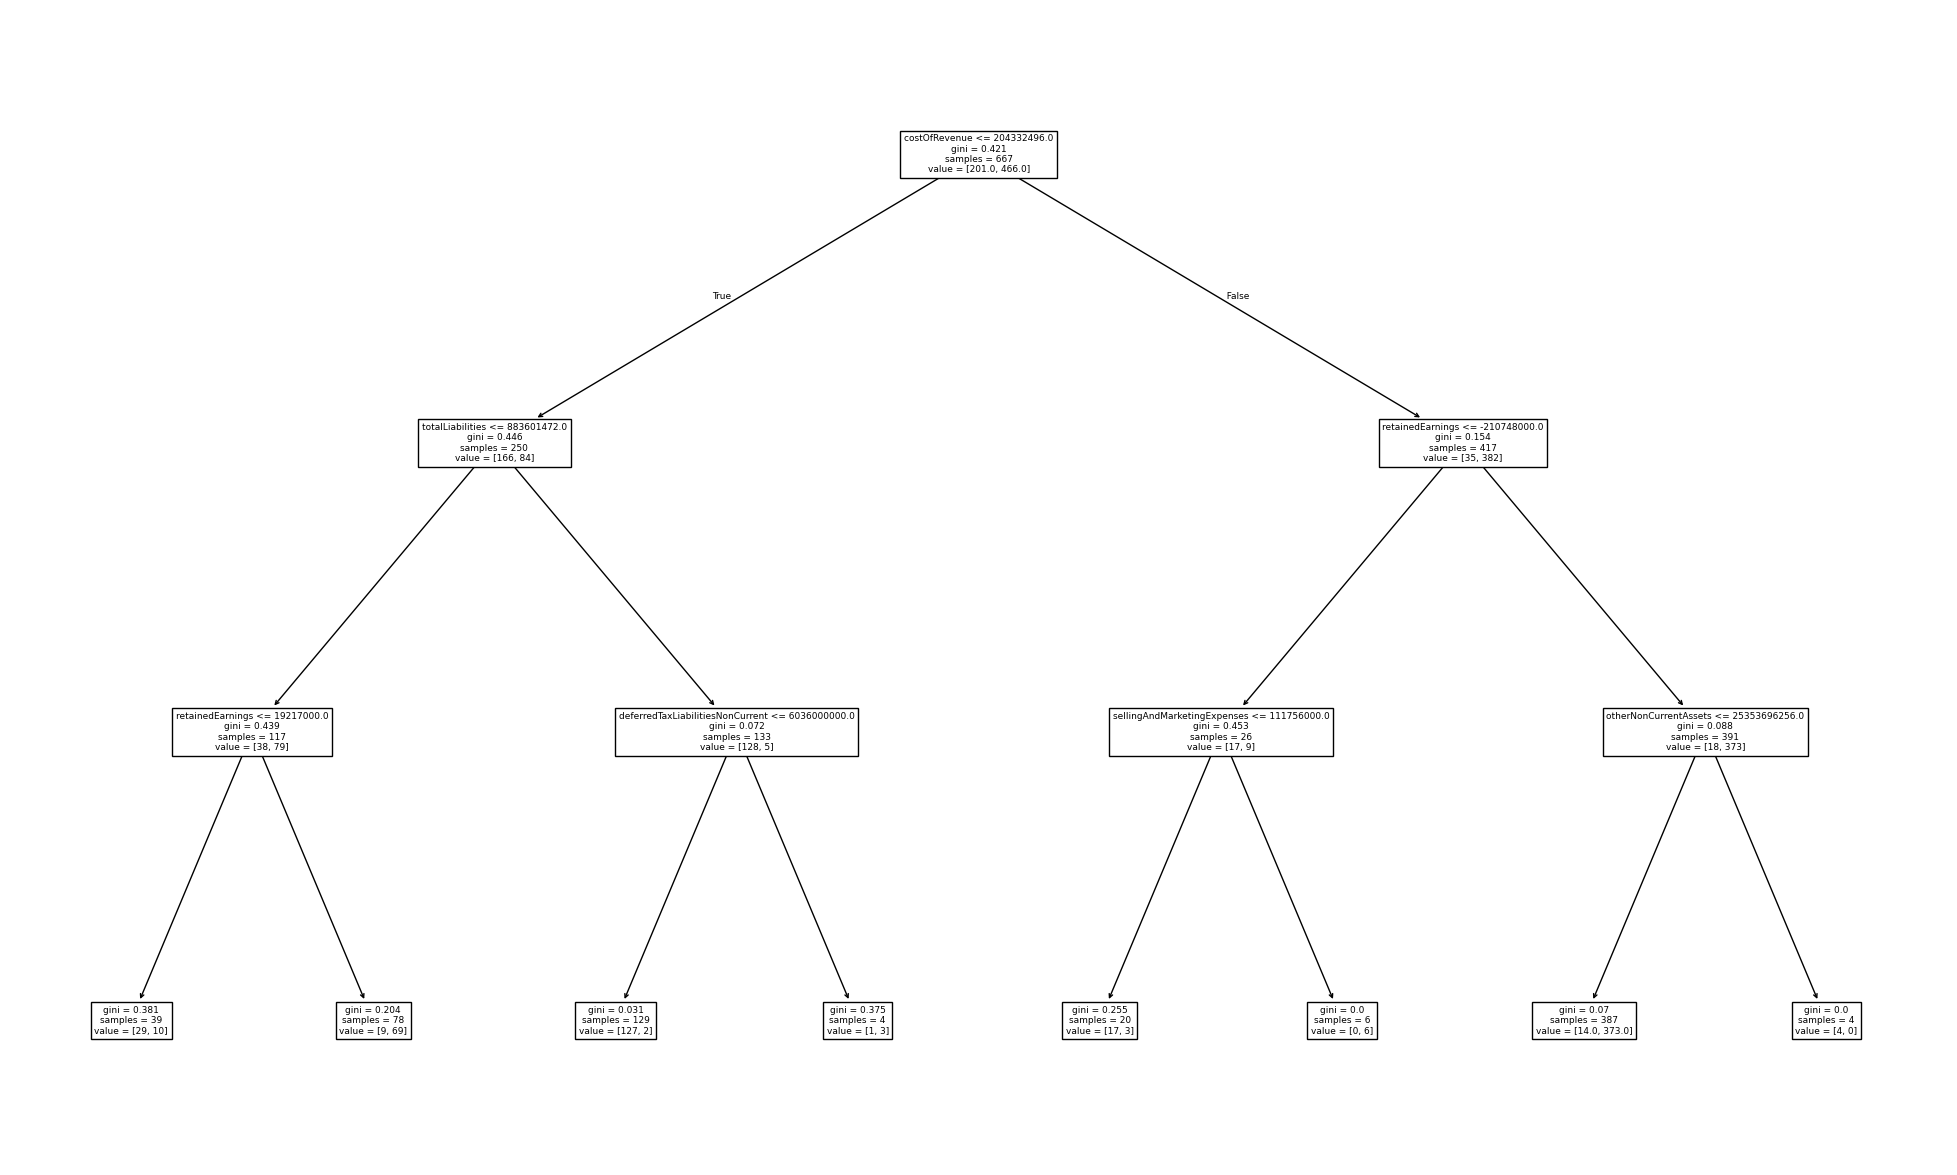

In [9]:
ax = subplots(figsize=(25,15))[1]
plot_tree(clf,
    feature_names=feature_names,
    ax=ax);

In [10]:
print(export_text(clf,
feature_names=feature_names,
show_weights=True))

|--- costOfRevenue <= 204332496.00
|   |--- totalLiabilities <= 883601472.00
|   |   |--- retainedEarnings <= 19217000.00
|   |   |   |--- weights: [29.00, 10.00] class: 0
|   |   |--- retainedEarnings >  19217000.00
|   |   |   |--- weights: [9.00, 69.00] class: 1
|   |--- totalLiabilities >  883601472.00
|   |   |--- deferredTaxLiabilitiesNonCurrent <= 6036000000.00
|   |   |   |--- weights: [127.00, 2.00] class: 0
|   |   |--- deferredTaxLiabilitiesNonCurrent >  6036000000.00
|   |   |   |--- weights: [1.00, 3.00] class: 1
|--- costOfRevenue >  204332496.00
|   |--- retainedEarnings <= -210748000.00
|   |   |--- sellingAndMarketingExpenses <= 111756000.00
|   |   |   |--- weights: [17.00, 3.00] class: 0
|   |   |--- sellingAndMarketingExpenses >  111756000.00
|   |   |   |--- weights: [0.00, 6.00] class: 1
|   |--- retainedEarnings >  -210748000.00
|   |   |--- otherNonCurrentAssets <= 25353696256.00
|   |   |   |--- weights: [14.00, 373.00] class: 1
|   |   |--- otherNonCurrentAsse

Cost of revenue seems to be the most important feature in this model

Next, we will split the data into some validation sets and see how the model performs on those

In [11]:
validation = skm.ShuffleSplit(n_splits=5,
                              test_size=0.2,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             zscore_save,
                             cv=validation)
results['test_score']

array([0.87313433, 0.92537313, 0.93283582, 0.93283582, 0.92537313])

The model is still performing well on the vadation sets.

Now let's actually create new models based on training and validations sets 

In [12]:
(X_train,
 X_test,
 zscore_train,
 zscore_test) = skm.train_test_split(X,
                                     zscore_save,
                                     test_size=0.2,
                                     random_state=0)

In [13]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, zscore_train)
accuracy_score(zscore_test, clf.predict(X_test))

0.9402985074626866

In [14]:
ccp_path = clf.cost_complexity_pruning_path(X_train, zscore_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [15]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, zscore_train)
grid.best_score_

0.9064640111809922

[Text(0.48863636363636365, 0.9285714285714286, 'costOfRevenue <= 212279000.0\nentropy = 0.882\nsamples = 533\nvalue = [160.0, 373.0]'),
 Text(0.25, 0.7857142857142857, 'interestExpense <= 3134000.0\nentropy = 0.92\nsamples = 203\nvalue = [135, 68]'),
 Text(0.3693181818181818, 0.8571428571428572, 'True  '),
 Text(0.09090909090909091, 0.6428571428571429, 'marketcap <= 135000000.0\nentropy = 0.761\nsamples = 68\nvalue = [15, 53]'),
 Text(0.045454545454545456, 0.5, 'entropy = 0.503\nsamples = 9\nvalue = [8, 1]'),
 Text(0.13636363636363635, 0.5, 'longTermDebt <= 151614376.0\nentropy = 0.525\nsamples = 59\nvalue = [7, 52]'),
 Text(0.09090909090909091, 0.35714285714285715, 'entropy = 0.232\nsamples = 53\nvalue = [2, 51]'),
 Text(0.18181818181818182, 0.35714285714285715, 'entropy = 0.65\nsamples = 6\nvalue = [5, 1]'),
 Text(0.4090909090909091, 0.6428571428571429, 'totalLiabilities <= 864459968.0\nentropy = 0.503\nsamples = 135\nvalue = [120, 15]'),
 Text(0.3181818181818182, 0.5, 'marketcap <= 

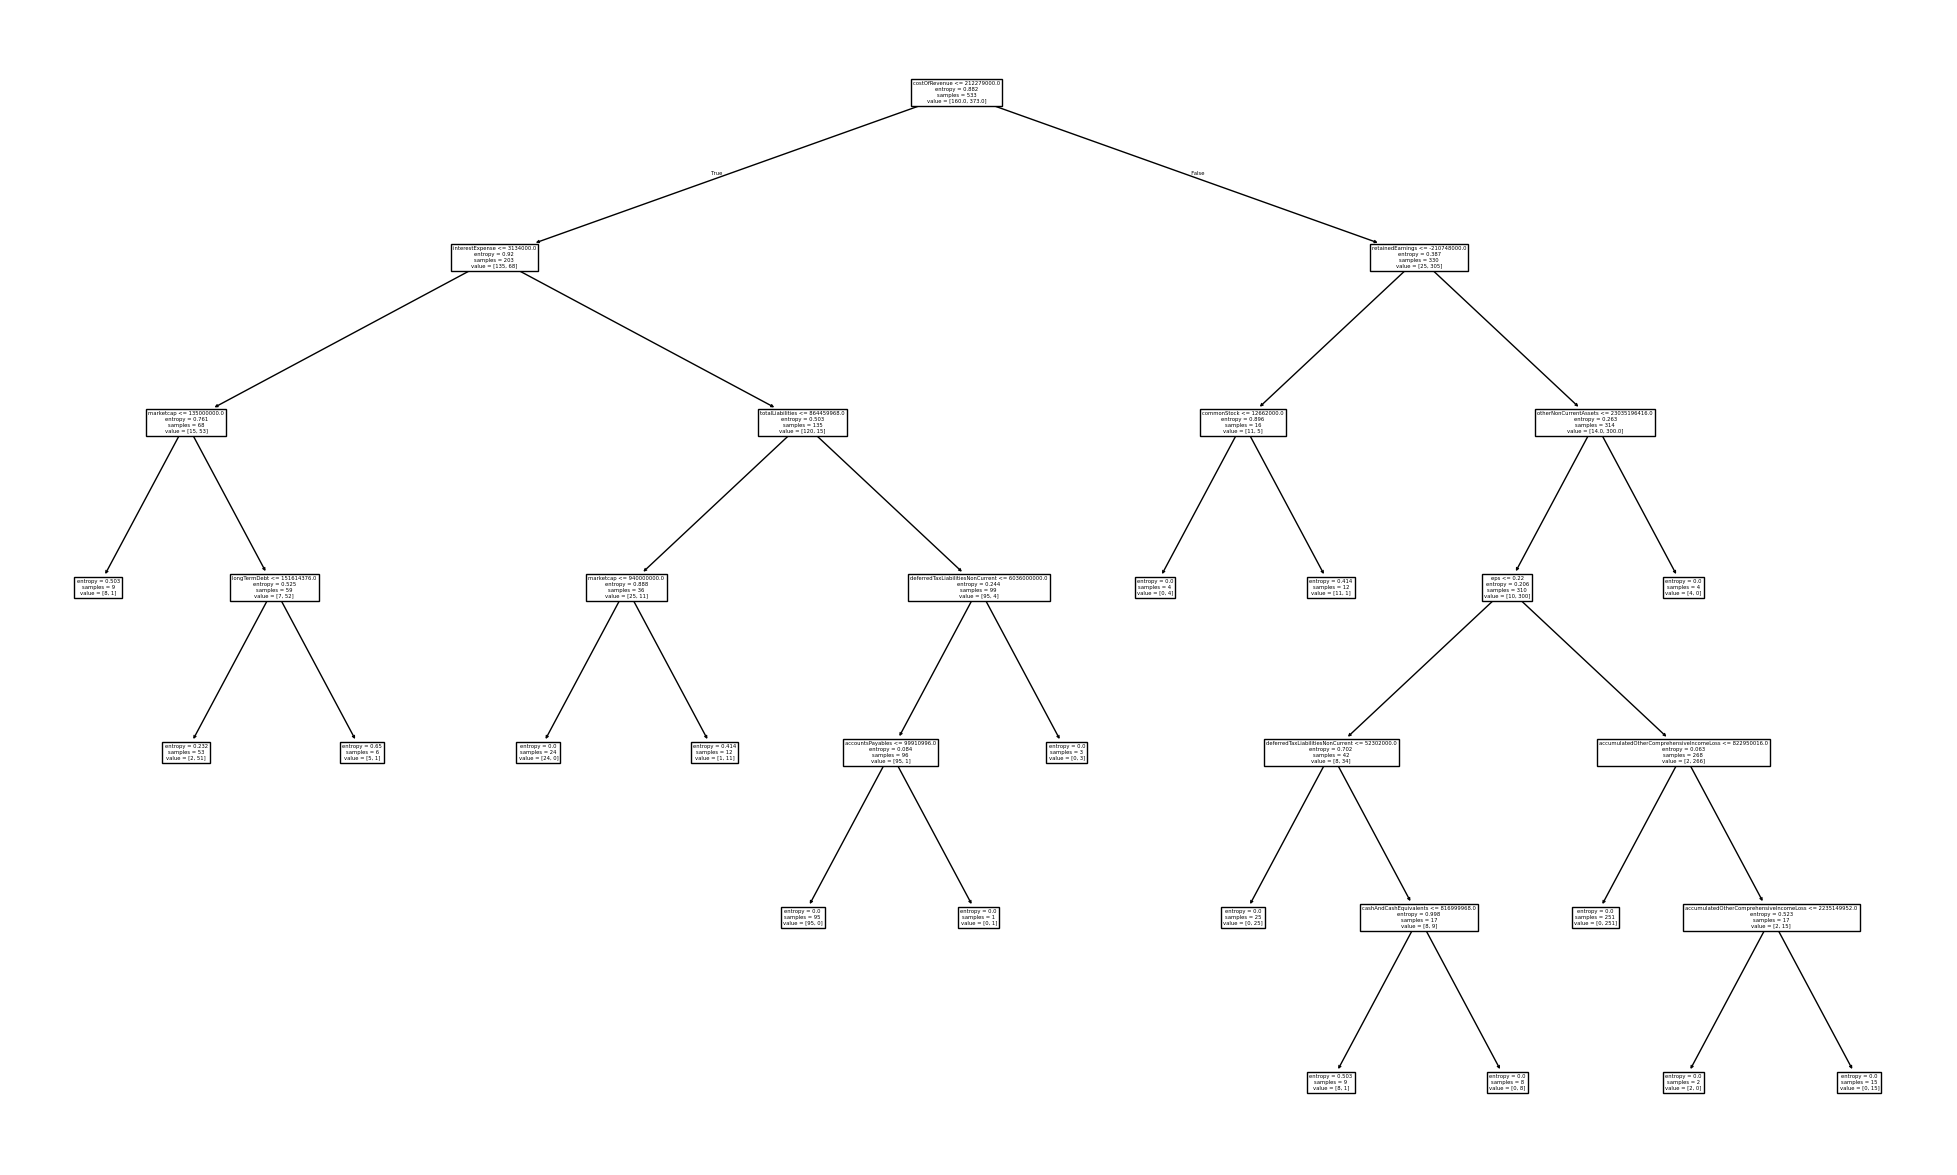

In [16]:
# plot the results of the grid search 
ax = subplots(figsize=(25, 15))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax)

In [17]:
best_.tree_.n_leaves

17

In [18]:
print(accuracy_score(zscore_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            zscore_test)
confusion

0.9253731343283582


Truth,0,1
Predicted,,
0,38,7
1,3,86


This is already a really good result.

Let's attempt to create forests. 1 using the entire dataset and 'distressed' as the classifier and the other with the 3std dataset and 'unhealthy' as the classifier.

In [26]:
#load datasets
df = pd.read_csv("../datasets/full_cleaned_dataset.csv")
df3std = pd.read_csv("../datasets/3std_dataset.csv")

#drop unrequired columns
df3std.drop(columns=['distressed', 'z_score'], inplace=True)

model = MS(df.select_dtypes(include=np.number).columns.drop('distressed'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

model3std = MS(df3std.select_dtypes(include=np.number).columns.drop('unhealthy'), intercept=False)
E = model3std.fit_transform(df3std)
feature_names3std = list(E.columns)
X3 = np.asarray(E)

In [33]:
# split the data into training and test sets (30% test size)
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                 df['distressed'],
                                 test_size=0.3,
                                 random_state=0)
 
(X3_train,
 X3_test,
 y3_train,
 y3_test) = skm.train_test_split(X3,
                                 df3std['unhealthy'],
                                 test_size=0.3,
                                 random_state=0)

In [34]:
bag_full = RF(max_features=X_train.shape[1], random_state=0)
bag_full.fit(X_train, y_train)

bag_3std = RF(max_features=X3_train.shape[1], random_state=0)
bag_3std.fit(X3_train, y3_train)

RandomForestRegressor(max_features=104, random_state=0)

0.012193140794223827

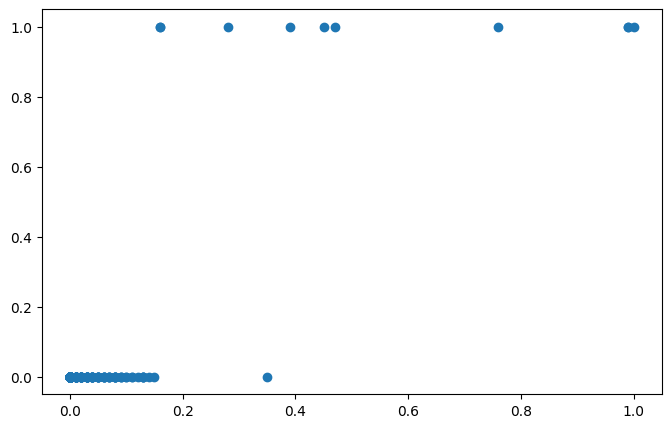

In [35]:
ax = subplots(figsize=(8,5))[1]
y_hat_bag = bag_full.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

0.0779

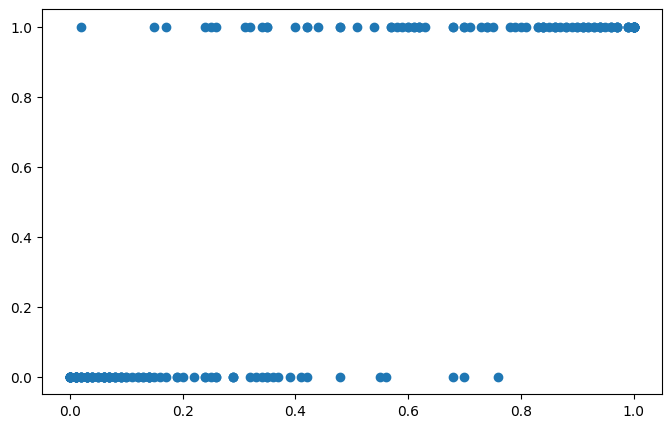

In [37]:
ax = subplots(figsize=(8,5))[1]
y3_hat_bag = bag_3std.predict(X3_test)
ax.scatter(y3_hat_bag, y3_test)
np.mean((y3_test -y3_hat_bag)**2)